In [ ]:
!pip install nibabel scikit-image
!pip install torchsummary
!pip install torchio


import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn import Module, Sequential, ModuleList
from torch.nn import Conv3d, ConvTranspose3d, BatchNorm3d, MaxPool3d, Dropout3d
from torch.nn import ReLU, Sigmoid, Softmax
import nibabel as nib
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
import torch.optim as optim
import glob
import random
warnings.filterwarnings('ignore')

print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("CUDA device:", torch.cuda.get_device_name(0))

PyTorch version: 2.6.0+cu124
CUDA available: True
CUDA device: Tesla T4


In [ ]:
# Install required packages in Colab
!pip install nilearn nibabel
!pip install git+https://github.com/miykael/gif_your_nifti

# Imports
import nilearn as nl
import nibabel as nib
import nilearn.plotting as nlplt
import gif_your_nifti.core as gif2nif


  Cloning https://github.com/miykael/gif_your_nifti to /tmp/pip-req-build-60ujhaj6
  Running command git clone --filter=blob:none --quiet https://github.com/miykael/gif_your_nifti /tmp/pip-req-build-60ujhaj6
  Resolved https://github.com/miykael/gif_your_nifti to commit 55c09c42921f4871cf43f63a303ab420a92a4f03
  Preparing metadata (setup.py) ... done


# BraTS Dataset

In [ ]:
# 1️⃣ Install Kaggle API
!pip install kaggle --upgrade --quiet

# 2️⃣ Create Kaggle directory
!mkdir -p ~/.kaggle

# 3️⃣ Copy your kaggle.json into the directory
!cp kaggle.json ~/.kaggle/

# 4️⃣ Set correct permissions
!chmod 600 ~/.kaggle/kaggle.json

# 5️⃣ Download dataset
!kaggle datasets download -d awsaf49/brats20-dataset-training-validation

# 6️⃣ Unzip dataset
!unzip -q brats20-dataset-training-validation.zip -d brats20_data


^C


KeyboardInterrupt: 

In [ ]:
# DEFINE seg-areas
SEGMENT_CLASSES = {
    0 : 'NOT tumor',
    1 : 'NECROTIC/CORE', # or NON-ENHANCING tumor CORE
    2 : 'EDEMA',
    3 : 'ENHANCING' # original 4 -> converted into 3 later
}

# there are 155 slices per volume
# to start at 5 and use 145 slices means we will skip the first 5 and last 5
VOLUME_SLICES = 100
VOLUME_START_AT = 22 # first slice of volume that we will include

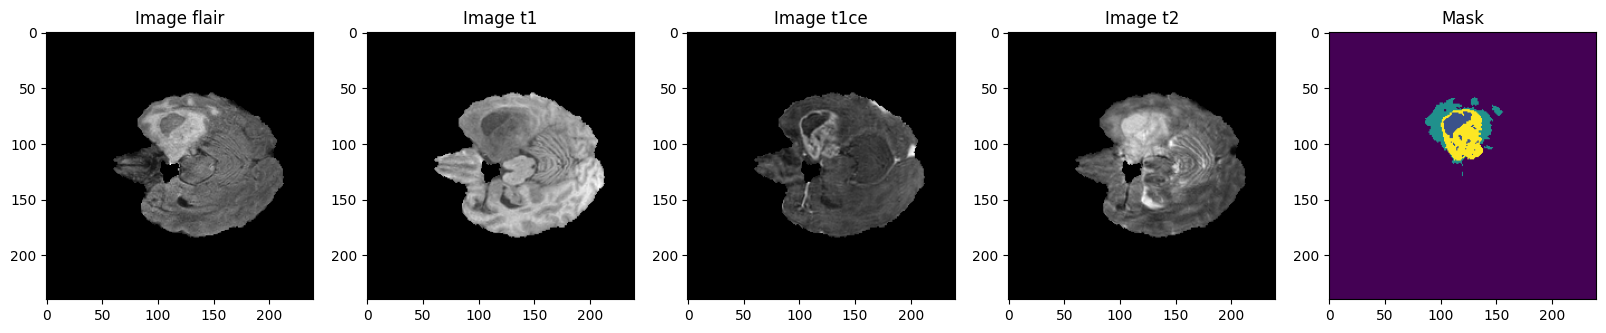

In [ ]:
# Install dependencies if not already installed
!pip install nibabel matplotlib --quiet

import nibabel as nib
import matplotlib.pyplot as plt

# Set dataset paths (update if your data is elsewhere)
TRAIN_DATASET_PATH = '/content/brats20_data/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData'
VALIDATION_DATASET_PATH = '/content/brats20_data/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData'

# Pick one patient case
patient_id = "BraTS20_Training_001"

# Load modalities
test_image_flair = nib.load(f"{TRAIN_DATASET_PATH}/{patient_id}/{patient_id}_flair.nii").get_fdata()
test_image_t1 = nib.load(f"{TRAIN_DATASET_PATH}/{patient_id}/{patient_id}_t1.nii").get_fdata()
test_image_t1ce = nib.load(f"{TRAIN_DATASET_PATH}/{patient_id}/{patient_id}_t1ce.nii").get_fdata()
test_image_t2 = nib.load(f"{TRAIN_DATASET_PATH}/{patient_id}/{patient_id}_t2.nii").get_fdata()
test_mask = nib.load(f"{TRAIN_DATASET_PATH}/{patient_id}/{patient_id}_seg.nii").get_fdata()

# Plot middle slice
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(20, 10))
slice_w = 25  # offset from middle
mid_slice = test_image_flair.shape[2] // 2 - slice_w  # use z-axis (depth)

ax1.imshow(test_image_flair[:, :, mid_slice], cmap='gray')
ax1.set_title('Image flair')

ax2.imshow(test_image_t1[:, :, mid_slice], cmap='gray')
ax2.set_title('Image t1')

ax3.imshow(test_image_t1ce[:, :, mid_slice], cmap='gray')
ax3.set_title('Image t1ce')

ax4.imshow(test_image_t2[:, :, mid_slice], cmap='gray')
ax4.set_title('Image t2')

ax5.imshow(test_mask[:, :, mid_slice])
ax5.set_title('Mask')

plt.show()


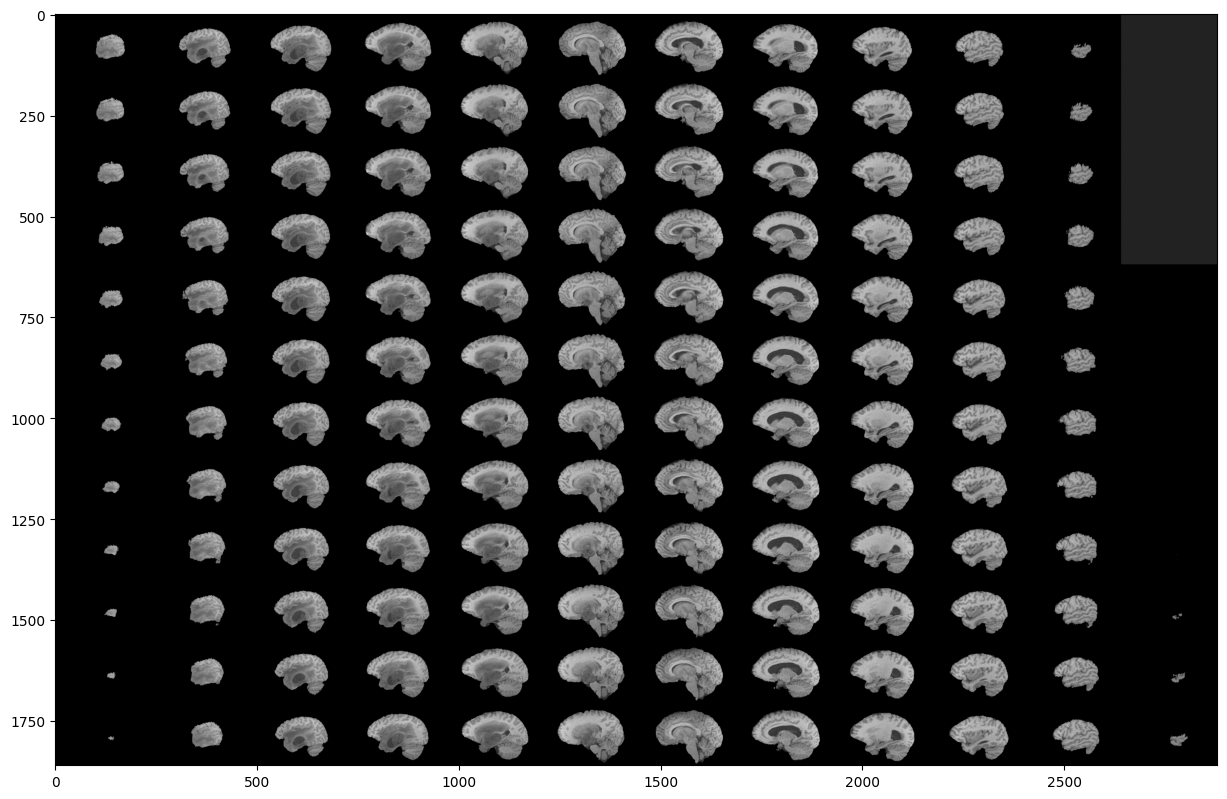

In [ ]:
import os
import cv2
import glob
import PIL
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from skimage import data
from skimage.util import montage
import skimage.transform as skTrans
from skimage.transform import rotate
from skimage.transform import resize
from PIL import Image, ImageOps

# Skip 50:-50 slices since there is not much to see
fig, ax1 = plt.subplots(1, 1, figsize = (15,15))
ax1.imshow(rotate(montage(test_image_t1[50:-50,:,:]), 90, resize=True), cmap ='gray')

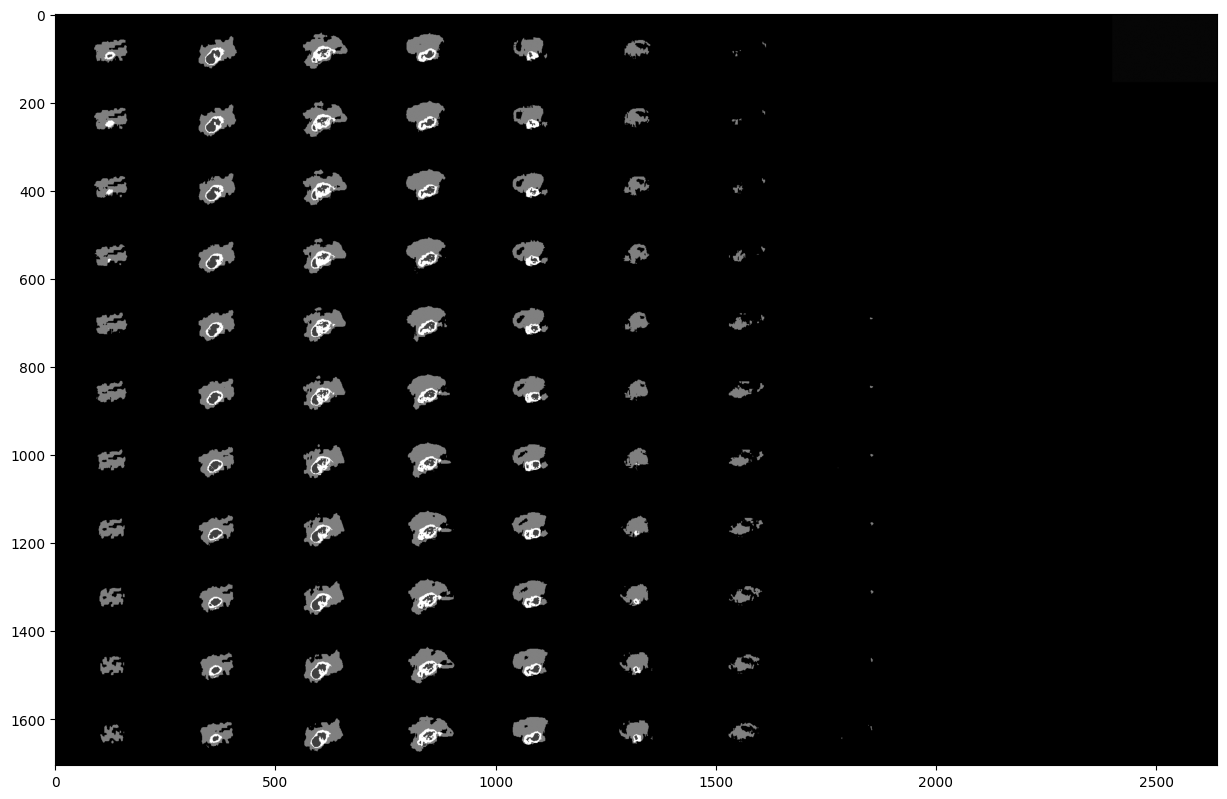

In [ ]:
# Skip 50:-50 slices since there is not much to see
fig, ax1 = plt.subplots(1, 1, figsize = (15,15))
ax1.imshow(rotate(montage(test_mask[60:-60,:,:]), 90, resize=True), cmap ='gray')

#3D UNET

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Module, Sequential, ModuleList
from torch.nn import Conv3d, ConvTranspose3d, BatchNorm3d, MaxPool3d, Dropout3d
from torch.nn import ReLU, Sigmoid, Softmax

class UNet3D_BraTS(Module):
    """
    3D U-Net for BraTS brain tumor segmentation

    Input: 4 channels (T1, T1Gd, T2, FLAIR)
    Output: 4 channels (background, necrotic core, peritumoral edema, enhancing tumor)
    """

    def __init__(self, in_channels=4, num_classes=4, feat_channels=[32, 64, 128, 256, 512],
                 residual='conv', dropout_rate=0.2):
        super(UNet3D_BraTS, self).__init__()

        self.num_classes = num_classes

        # Encoder downsamplers - adjusted for 3D brain volumes
        self.pool1 = MaxPool3d(2)  # Full 3D pooling for brain data
        self.pool2 = MaxPool3d(2)
        self.pool3 = MaxPool3d(2)
        self.pool4 = MaxPool3d(2)

        # Encoder convolutions
        self.conv_blk1 = Conv3D_Block(in_channels, feat_channels[0], residual=residual, dropout_rate=dropout_rate)
        self.conv_blk2 = Conv3D_Block(feat_channels[0], feat_channels[1], residual=residual, dropout_rate=dropout_rate)
        self.conv_blk3 = Conv3D_Block(feat_channels[1], feat_channels[2], residual=residual, dropout_rate=dropout_rate)
        self.conv_blk4 = Conv3D_Block(feat_channels[2], feat_channels[3], residual=residual, dropout_rate=dropout_rate)
        self.conv_blk5 = Conv3D_Block(feat_channels[3], feat_channels[4], residual=residual, dropout_rate=dropout_rate)

        # Decoder convolutions - FIXED: Proper channel calculations for skip connections
        self.dec_conv_blk4 = Conv3D_Block(feat_channels[3] + feat_channels[3], feat_channels[3], residual=residual, dropout_rate=dropout_rate)  # 256 + 256 = 512 -> 256
        self.dec_conv_blk3 = Conv3D_Block(feat_channels[2] + feat_channels[2], feat_channels[2], residual=residual, dropout_rate=dropout_rate)  # 128 + 128 = 256 -> 128
        self.dec_conv_blk2 = Conv3D_Block(feat_channels[1] + feat_channels[1], feat_channels[1], residual=residual, dropout_rate=dropout_rate)  # 64 + 64 = 128 -> 64
        self.dec_conv_blk1 = Conv3D_Block(feat_channels[0] + feat_channels[0], feat_channels[0], residual=residual, dropout_rate=dropout_rate)  # 32 + 32 = 64 -> 32

        # Decoder upsamplers - FIXED: Proper upsampling channels
        self.deconv_blk4 = Deconv3D_Block(feat_channels[4], feat_channels[3])  # 512 -> 256
        self.deconv_blk3 = Deconv3D_Block(feat_channels[3], feat_channels[2])  # 256 -> 128
        self.deconv_blk2 = Deconv3D_Block(feat_channels[2], feat_channels[1])  # 128 -> 64
        self.deconv_blk1 = Deconv3D_Block(feat_channels[1], feat_channels[0])  # 64 -> 32

        # Final segmentation layer
        self.final_conv = Conv3d(feat_channels[0], num_classes, kernel_size=1, stride=1, padding=0, bias=True)

        # Activation - Softmax for multi-class segmentation
        self.softmax = Softmax(dim=1)

    def forward(self, x):
        # Encoder
        x1 = self.conv_blk1(x)        # [B, 32, H, W, D]
        x_low1 = self.pool1(x1)       # [B, 32, H/2, W/2, D/2]

        x2 = self.conv_blk2(x_low1)   # [B, 64, H/2, W/2, D/2]
        x_low2 = self.pool2(x2)       # [B, 64, H/4, W/4, D/4]

        x3 = self.conv_blk3(x_low2)   # [B, 128, H/4, W/4, D/4]
        x_low3 = self.pool3(x3)       # [B, 128, H/8, W/8, D/8]

        x4 = self.conv_blk4(x_low3)   # [B, 256, H/8, W/8, D/8]
        x_low4 = self.pool4(x4)       # [B, 256, H/16, W/16, D/16]

        # Bottleneck
        base = self.conv_blk5(x_low4) # [B, 512, H/16, W/16, D/16]

        # Decoder with skip connections
        # Level 4: upsample 512->256, concat with x4 (256), total = 512
        d4 = torch.cat([self.deconv_blk4(base), x4], dim=1)  # [B, 512, H/8, W/8, D/8]
        d_high4 = self.dec_conv_blk4(d4)                     # [B, 256, H/8, W/8, D/8]

        # Level 3: upsample 256->128, concat with x3 (128), total = 256
        d3 = torch.cat([self.deconv_blk3(d_high4), x3], dim=1)  # [B, 256, H/4, W/4, D/4]
        d_high3 = self.dec_conv_blk3(d3)                         # [B, 128, H/4, W/4, D/4]

        # Level 2: upsample 128->64, concat with x2 (64), total = 128
        d2 = torch.cat([self.deconv_blk2(d_high3), x2], dim=1)  # [B, 128, H/2, W/2, D/2]
        d_high2 = self.dec_conv_blk2(d2)                         # [B, 64, H/2, W/2, D/2]

        # Level 1: upsample 64->32, concat with x1 (32), total = 64
        d1 = torch.cat([self.deconv_blk1(d_high2), x1], dim=1)  # [B, 64, H, W, D]
        d_high1 = self.dec_conv_blk1(d1)                         # [B, 32, H, W, D]

        # Final prediction
        logits = self.final_conv(d_high1)  # [B, num_classes, H, W, D]

        # Return both logits (for loss calculation) and probabilities (for inference)
        if self.training:
            return logits
        else:
            return self.softmax(logits)

class Conv3D_Block(Module):
    """
    Enhanced 3D Convolution Block with dropout and improved residual connections
    """

    def __init__(self, inp_feat, out_feat, kernel=3, stride=1, padding=1, residual=None, dropout_rate=0.2):
        super(Conv3D_Block, self).__init__()

        self.conv1 = Sequential(
            Conv3d(inp_feat, out_feat, kernel_size=kernel,
                   stride=stride, padding=padding, bias=False),
            BatchNorm3d(out_feat),
            ReLU(inplace=True),
            Dropout3d(dropout_rate)
        )

        self.conv2 = Sequential(
            Conv3d(out_feat, out_feat, kernel_size=kernel,
                   stride=stride, padding=padding, bias=False),
            BatchNorm3d(out_feat),
            ReLU(inplace=True),
            Dropout3d(dropout_rate)
        )

        self.residual = residual

        if self.residual == 'conv' and inp_feat != out_feat:
            self.residual_upsampler = Conv3d(inp_feat, out_feat, kernel_size=1, bias=False)
        else:
            self.residual_upsampler = None

    def forward(self, x):
        res = x
        out = self.conv1(x)
        out = self.conv2(out)

        if self.residual == 'conv':
            if self.residual_upsampler is not None:
                res = self.residual_upsampler(res)
            return out + res
        else:
            return out

class Deconv3D_Block(Module):
    """
    3D Transposed Convolution Block for upsampling
    """

    def __init__(self, inp_feat, out_feat, kernel=2, stride=2, padding=0):
        super(Deconv3D_Block, self).__init__()

        self.deconv = Sequential(
            ConvTranspose3d(inp_feat, out_feat, kernel_size=kernel,
                           stride=stride, padding=padding, bias=False),
            BatchNorm3d(out_feat),
            ReLU(inplace=True)
        )

    def forward(self, x):
        return self.deconv(x)



# Loss Functions and Metrics

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DiceLoss(nn.Module):
    def __init__(self, num_classes=4, smooth=1e-6):
        super(DiceLoss, self).__init__()
        self.num_classes = num_classes
        self.smooth = smooth

    def forward(self, input, target):
        target_one_hot = F.one_hot(target, num_classes=self.num_classes)
        target_one_hot = target_one_hot.permute(0, 4, 1, 2, 3).float()
        input_soft = F.softmax(input, dim=1)

        dice_scores = []
        for i in range(self.num_classes):
            input_flat = input_soft[:, i].contiguous().view(-1)
            target_flat = target_one_hot[:, i].contiguous().view(-1)

            intersection = (input_flat * target_flat).sum()
            dice = (2 * intersection + self.smooth) / (input_flat.sum() + target_flat.sum() + self.smooth)
            dice_scores.append(dice)

        dice_scores = torch.stack(dice_scores)
        mean_dice = dice_scores.mean()
        return 1 - mean_dice, dice_scores

class CombinedLoss(nn.Module):
    def __init__(self, num_classes=4, alpha=0.5, deep_supervision=True):
        super(CombinedLoss, self).__init__()
        self.ce_loss = nn.CrossEntropyLoss()
        self.dice_loss = DiceLoss(num_classes)
        self.alpha = alpha
        self.deep_supervision = deep_supervision
        self.ds_weights = [0.5, 0.3, 0.2]  # Weighting for deep supervision outputs

    def forward(self, inputs, target):
        if self.deep_supervision and isinstance(inputs, (list, tuple)):
            total_loss = 0
            dice_scores = []

            for i, output in enumerate(inputs):
                ce = self.ce_loss(output, target)
                dice_loss_value, scores = self.dice_loss(output, target)

                if i == 0:  # Main output
                    weight = 1.0
                    dice_scores = scores
                else:  # Deep supervision outputs
                    weight = self.ds_weights[i-1]

                combined = self.alpha * ce + (1 - self.alpha) * dice_loss_value
                total_loss += weight * combined

            return total_loss, dice_scores
        else:
            ce = self.ce_loss(inputs, target)
            dice_loss_value, dice_scores = self.dice_loss(inputs, target)
            combined = self.alpha * ce + (1 - self.alpha) * dice_loss_value
            return combined, dice_scores

# Dataset Loader

In [ ]:
import os
import glob
import torch
import numpy as np
import nibabel as nib
import random
import torchio as tio
from torch.utils.data import Dataset, DataLoader


class BraTS3DPatchDataset(Dataset):
    """
    3D BraTS Dataset for patch-based training of 3D U-Net.
    Loads 3D patches from volumes in the dataset.
    Supports:
      - Training (with segmentation labels)
      - Validation (without segmentation labels)
      - Tumor-aware patch filtering with configurable background ratio
    """

    def __init__(self, patient_ids, data_path, patch_size=(128, 128, 64), stride=(64, 64, 32),
                 has_seg=True, bg_ratio=0.5, augment=False):
        """
        Args:
            patient_ids: list of patient IDs
            data_path: root directory of BraTS data
            patch_size: size of extracted patches (H, W, D)
            stride: stride for sliding window
            has_seg: whether segmentation labels are available (True for training, False for validation)
            bg_ratio: how many background patches to keep relative to tumor patches (e.g. 0.5 = 50%)
            augment: whether to apply data augmentation
        """
        self.patient_ids = patient_ids
        self.data_path = data_path
        self.patch_size = patch_size
        self.stride = stride
        self.has_seg = has_seg
        self.bg_ratio = bg_ratio
        self.augment = augment

        # Precompute patch list
        self.data_list = self._create_patch_list()

        # Augmentation pipeline with torchio
        self.transform = tio.Compose([
            tio.RandomFlip(axes=(0, 1, 2), flip_probability=0.5),
            tio.RandomNoise(mean=0, std=(0, 0.1)),
        ])

    def _load_volume(self, patient_id):
        """Load 3D volumes (4 modalities + optional segmentation) for a patient"""
        case_path = os.path.join(self.data_path, patient_id)

        # Load modalities
        flair = nib.load(os.path.join(case_path, f"{patient_id}_flair.nii")).get_fdata()
        t1 = nib.load(os.path.join(case_path, f"{patient_id}_t1.nii")).get_fdata()
        t1ce = nib.load(os.path.join(case_path, f"{patient_id}_t1ce.nii")).get_fdata()
        t2 = nib.load(os.path.join(case_path, f"{patient_id}_t2.nii")).get_fdata()

        seg = None
        if self.has_seg:  # Only for training
            seg = nib.load(os.path.join(case_path, f"{patient_id}_seg.nii")).get_fdata()
            seg[seg == 4] = 3  # Convert labels: 4 → 3

        # Stack modalities → [C, H, W, D]
        image = np.stack([flair, t1, t1ce, t2], axis=0)

        # Normalize each modality separately
        for c in range(image.shape[0]):
            if image[c].max() > 0:
                image[c] = (image[c] - image[c].mean()) / (image[c].std() + 1e-8)

        return image, seg

    def _create_patch_list(self):
        """Generate list of (patient_id, h, w, d) patch start indices with tumor filtering"""
        patch_list = []
        background_patches = []

        for patient_id in self.patient_ids:
            image, seg = self._load_volume(patient_id)
            _, H, W, D = image.shape
            ph, pw, pd = self.patch_size
            sh, sw, sd = self.stride

            for h in range(0, H - ph + 1, sh):
                for w in range(0, W - pw + 1, sw):
                    for d in range(0, D - pd + 1, sd):
                        if self.has_seg and seg is not None:
                            seg_patch = seg[h:h + ph, w:w + pw, d:d + pd]
                            if np.any(seg_patch > 0):
                                patch_list.append((patient_id, h, w, d))  # tumor patch
                            else:
                                background_patches.append((patient_id, h, w, d))  # background patch
                        else:
                            patch_list.append((patient_id, h, w, d))  # validation (no seg filtering)

        # Add some background patches to balance dataset
        if self.has_seg and len(patch_list) > 0:
            keep_bg = min(len(background_patches), int(len(patch_list) * self.bg_ratio))
            patch_list.extend(random.sample(background_patches, keep_bg))

            print(f"[INFO] Tumor patches: {len(patch_list) - keep_bg}, Background patches added: {keep_bg}")

        random.shuffle(patch_list)
        return patch_list

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        patient_id, h, w, d = self.data_list[idx]
        image, seg = self._load_volume(patient_id)

        ph, pw, pd = self.patch_size
        image_patch = image[:, h:h + ph, w:w + pw, d:d + pd].astype(np.float32)

        if self.has_seg and seg is not None:
            seg_patch = seg[h:h + ph, w:w + pw, d:d + pd].astype(np.int16)

            if self.augment:
                subject = tio.Subject(
                    image=tio.ScalarImage(tensor=image_patch),
                    label=tio.LabelMap(tensor=seg_patch[None])  # add channel dim for label
                )
                subject = self.transform(subject)
                image_patch = subject.image.data
                seg_patch = subject.label.data[0]
            else:
                seg_patch = torch.from_numpy(seg_patch)

            return torch.FloatTensor(image_patch), seg_patch.long()

        else:
            if self.augment:
                subject = tio.Subject(image=tio.ScalarImage(tensor=image_patch))
                subject = self.transform(subject)
                image_patch = subject.image.data
            return torch.FloatTensor(image_patch)


def get_patient_ids(data_dir, require_seg=True):
    """Get all patient IDs in a dataset folder"""
    patient_ids = []
    for patient_dir in glob.glob(os.path.join(data_dir, "BraTS20_*")):
        patient_name = os.path.basename(patient_dir)
        required_files = ['_flair.nii', '_t1.nii', '_t1ce.nii', '_t2.nii']
        if require_seg:
            required_files.append('_seg.nii')
        if all(os.path.exists(os.path.join(patient_dir, patient_name + suffix)) for suffix in required_files):
            patient_ids.append(patient_name)
    return patient_ids


In [ ]:
pip install torchio

# Training Setup

In [ ]:
import os
import random
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
import torchio as tio

TRAIN_DATASET_PATH = '/content/brats20_data/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData'
VALIDATION_DATASET_PATH = '/content/brats20_data/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData'

NUM_EPOCHS=8
BATCH_SIZE=2
LEARNING_RATE=1e-5
DEVICE=torch.device("cuda" if torch.cuda.is_available() else "cpu")
SAVE_DIR='/kaggle/working/'
os.makedirs(SAVE_DIR, exist_ok=True)


train_patient_ids_all=get_patient_ids(TRAIN_DATASET_PATH, require_seg=True)


train_patient_ids = train_patient_ids_all[:60]
val_patient_ids = train_patient_ids_all[60:80]

print(f"[INFO] Using {len(train_patient_ids)} training patients")
print(f"[INFO] Using {len(val_patient_ids)} validation patients")


[INFO] Using 60 training patients
[INFO] Using 20 validation patients


In [ ]:
train_dataset = BraTS3DPatchDataset(train_patient_ids, TRAIN_DATASET_PATH, has_seg=True, bg_ratio=0.1,augment=True)
val_dataset = BraTS3DPatchDataset(val_patient_ids, TRAIN_DATASET_PATH, has_seg=True, bg_ratio=0.1,augment=False)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=3,pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=3,pin_memory=True)

print(f"[INFO] Training patches after filtering: {len(train_dataset)}")
print(f"[INFO] Validation patches: {len(val_dataset)}")


# Test a training patch
image_patch_train, seg_patch_train = train_dataset[0]
print(f"Train patch image shape: {image_patch_train.shape}")
print(f"Train patch seg shape: {seg_patch_train.shape}")
print(f"Unique labels in train seg: {torch.unique(seg_patch_train)}")

# Test a val patch
image_patch_val, seg_patch_val = val_dataset[0]
print(f"val patch image shape: {image_patch_val.shape}")
print(f"val patch seg shape: {seg_patch_val.shape}")
print(f"Unique labels in val seg: {torch.unique(seg_patch_val)}")


[INFO] Tumor patches: 556, Background patches added: 55
[INFO] Tumor patches: 188, Background patches added: 18
[INFO] Training patches after filtering: 611
[INFO] Validation patches: 206
Train patch image shape: torch.Size([4, 128, 128, 64])
Train patch seg shape: torch.Size([128, 128, 64])
Unique labels in train seg: tensor([0, 1, 2])
val patch image shape: torch.Size([4, 128, 128, 64])
val patch seg shape: torch.Size([128, 128, 64])
Unique labels in val seg: tensor([0, 1, 2])


In [ ]:
model = UNet3D_BraTS(
        in_channels=4,
        num_classes=4,
        feat_channels=[16, 32, 64, 128, 256],
        residual='conv',
        dropout_rate=0.2
    ).to(DEVICE)
criterion = CombinedLoss(num_classes=4, alpha=0.5)
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)



from torchsummary import summary

print("Model Summary:")
summary(model, input_size=(4, 128, 128, 64))

Model Summary:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1     [-1, 16, 128, 128, 64]           1,728
       BatchNorm3d-2     [-1, 16, 128, 128, 64]              32
              ReLU-3     [-1, 16, 128, 128, 64]               0
         Dropout3d-4     [-1, 16, 128, 128, 64]               0
            Conv3d-5     [-1, 16, 128, 128, 64]           6,912
       BatchNorm3d-6     [-1, 16, 128, 128, 64]              32
              ReLU-7     [-1, 16, 128, 128, 64]               0
         Dropout3d-8     [-1, 16, 128, 128, 64]               0
            Conv3d-9     [-1, 16, 128, 128, 64]              64
     Conv3D_Block-10     [-1, 16, 128, 128, 64]               0
        MaxPool3d-11       [-1, 16, 64, 64, 32]               0
           Conv3d-12       [-1, 32, 64, 64, 32]          13,824
      BatchNorm3d-13       [-1, 32, 64, 64, 32]              64
             ReLU-14    

# Training Loop

In [ ]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import os
from tqdm import tqdm

def calculate_dice_scores(input, target, num_classes=4, smooth=1e-6):
    """Calculate dice scores per class and mean dice score"""
    target_one_hot = F.one_hot(target, num_classes=num_classes)
    target_one_hot = target_one_hot.permute(0, 4, 1, 2, 3).float()
    input_soft = F.softmax(input, dim=1)

    dice_scores = []
    for i in range(num_classes):
        input_flat = input_soft[:, i].contiguous().view(-1)
        target_flat = target_one_hot[:, i].contiguous().view(-1)

        intersection = (input_flat * target_flat).sum()
        dice = (2 * intersection + smooth) / (input_flat.sum() + target_flat.sum() + smooth)
        dice_scores.append(dice.item())

    return dice_scores, sum(dice_scores) / len(dice_scores)

# Store metrics per epoch
history = {
    "train_loss": [],
    "val_loss": [],
    "train_dice": [],
    "val_dice": [],
    "train_dice_per_class": [],
    "val_dice_per_class": []
}

best_val_dice = 0.0
epochs_no_improve = 0
patience = 5

for epoch in range(NUM_EPOCHS):
    print(f"\n===== Epoch {epoch+1}/{NUM_EPOCHS} =====")

    # ---------- TRAIN ----------
    model.train()
    running_loss = 0
    dice_all = []
    per_class_dice_sum = torch.zeros(4)

    for batch_idx, (images, targets) in enumerate(tqdm(train_loader, desc="Training", leave=False)):
        images = images.to(DEVICE, dtype=torch.float32)
        targets = targets.to(DEVICE, dtype=torch.long)

        # Forward pass
        outputs = model(images)

        # Calculate loss using your CombinedLoss
        loss, dice_scores = criterion(outputs, targets)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Accumulate metrics
        running_loss += loss.item()
        # dice_scores is a tensor, so we need to detach and move to CPU
        per_class_dice_sum += dice_scores.detach().cpu()
        dice_all.append(dice_scores.mean().detach().cpu().item())

    # Calculate average training metrics
    avg_train_loss = running_loss / len(train_loader)
    avg_train_dice = sum(dice_all) / len(dice_all)
    avg_train_dice_per_class = per_class_dice_sum / len(train_loader)

    print(f"[Train] Loss: {avg_train_loss:.4f} | Mean Dice: {avg_train_dice:.4f}")
    print(f"[Train] Dice per class: {avg_train_dice_per_class.tolist()}")

    # Store training metrics
    history["train_loss"].append(avg_train_loss)
    history["train_dice"].append(avg_train_dice)
    history["train_dice_per_class"].append(avg_train_dice_per_class.tolist())

    # ---------- VALIDATION ----------
    model.eval()
    val_loss = 0
    dice_all_val = []
    per_class_dice_sum_val = torch.zeros(4)

    with torch.no_grad():
        # Check if validation loader has targets
        val_has_targets = True  # Set this based on your validation data structure

        for batch_idx, batch_data in enumerate(tqdm(val_loader, desc="Validation", leave=False)):
            if val_has_targets:
                # If validation loader provides both images and targets
                images, targets = batch_data
                targets = targets.to(DEVICE, dtype=torch.long)
            else:
                # If validation loader only provides images
                images = batch_data
                # Create dummy targets (this is not ideal for real evaluation)
                targets = torch.zeros((images.shape[0], *images.shape[2:]),
                                    dtype=torch.long, device=DEVICE)

            images = images.to(DEVICE, dtype=torch.float32)
            outputs = model(images)

            if val_has_targets:
                # Calculate validation loss if we have ground truth
                loss, dice_scores = criterion(outputs, targets)
                val_loss += loss.item()

                # Accumulate dice scores (from criterion)
                per_class_dice_sum_val += dice_scores.detach().cpu()
                dice_all_val.append(dice_scores.mean().detach().cpu().item())
            else:
                # If no ground truth, use dummy calculation (not recommended)
                dice_per_class, dice_mean = calculate_dice_scores(outputs, targets)
                dice_all_val.append(dice_mean)
                per_class_dice_sum_val += torch.tensor(dice_per_class)

    # Calculate average validation metrics
    if val_has_targets:
        avg_val_loss = val_loss / len(val_loader)
        avg_val_dice = sum(dice_all_val) / len(dice_all_val)
        avg_val_dice_per_class = per_class_dice_sum_val / len(val_loader)

        print(f"[Val] Loss: {avg_val_loss:.4f} | Mean Dice: {avg_val_dice:.4f}")
        print(f"[Val] Dice per class: {avg_val_dice_per_class.tolist()}")

        history["val_loss"].append(avg_val_loss)
    else:
        avg_val_dice = sum(dice_all_val) / len(dice_all_val)
        avg_val_dice_per_class = per_class_dice_sum_val / len(val_loader)

        print(f"[Val] Mean Dice (dummy): {avg_val_dice:.4f}")
        print(f"[Val] Dice per class (dummy): {avg_val_dice_per_class.tolist()}")

        history["val_loss"].append(None)

    history["val_dice"].append(avg_val_dice)
    history["val_dice_per_class"].append(avg_val_dice_per_class.tolist())

    # ---------- LEARNING RATE SCHEDULER (Optional) ----------
    # if scheduler is not None:
    #     scheduler.step(avg_val_loss if val_has_targets else avg_val_dice)

    # ---------- SAVE MODEL ----------
    checkpoint = {
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_loss': avg_train_loss,
        'val_loss': avg_val_loss if val_has_targets else None,
        'train_dice': avg_train_dice,
        'val_dice': avg_val_dice,
        'history': history
    }

    torch.save(checkpoint, os.path.join(SAVE_DIR, f"checkpoint_epoch_{epoch+1}.pth"))

    # Save best model based on validation dice
    if avg_val_dice > best_val_dice:
        best_val_dice = avg_val_dice
        epochs_no_improve = 0
        torch.save(checkpoint, os.path.join(SAVE_DIR, "best_model.pth"))
        print(f"New best model saved with Val Dice: {best_val_dice:.4f}")
    else:
        epochs_no_improve += 1
        print(f"No improvement in validation dice for {epochs_no_improve} epoch(s).")

        if epochs_no_improve >= patience:
            print(f"Early stopping triggered. No improvement for {patience} consecutive epochs.")
            break

print("Training completed!")
print(f"Best validation dice score: {best_val_dice:.4f}")


===== Epoch 1/8 =====


[Train] Loss: 0.7601 | Mean Dice: 0.1967
[Train] Dice per class: [0.6817596554756165, 0.03340262919664383, 0.058783214539289474, 0.012770307250320911]


[Val] Loss: 0.8918 | Mean Dice: 0.1598
[Val] Dice per class: [0.5639018416404724, 0.021336879581212997, 0.04119405895471573, 0.01267695426940918]
New best model saved with Val Dice: 0.1598

===== Epoch 2/8 =====


[Train] Loss: 0.4748 | Mean Dice: 0.2837
[Train] Dice per class: [0.9109737277030945, 0.08050962537527084, 0.11474274098873138, 0.028755247592926025]


[Val] Loss: 0.8227 | Mean Dice: 0.1738
[Val] Dice per class: [0.61691814661026, 0.01654488779604435, 0.04741073399782181, 0.014458456076681614]
New best model saved with Val Dice: 0.1738

===== Epoch 3/8 =====


[Train] Loss: 0.3974 | Mean Dice: 0.3387
[Train] Dice per class: [0.9623977541923523, 0.1237102672457695, 0.20901118218898773, 0.059661492705345154]


[Val] Loss: 0.8032 | Mean Dice: 0.1796
[Val] Dice per class: [0.6309045553207397, 0.018518846482038498, 0.0531722716987133, 0.015985604375600815]
New best model saved with Val Dice: 0.1796

===== Epoch 4/8 =====


[Train] Loss: 0.3476 | Mean Dice: 0.4030
[Train] Dice per class: [0.976650059223175, 0.1838257610797882, 0.27685412764549255, 0.17476291954517365]


[Val] Loss: 0.7945 | Mean Dice: 0.1844
[Val] Dice per class: [0.6353245973587036, 0.019576841965317726, 0.05848783627152443, 0.024070441722869873]
New best model saved with Val Dice: 0.1844

===== Epoch 5/8 =====


[Train] Loss: 0.3066 | Mean Dice: 0.4662
[Train] Dice per class: [0.9841021299362183, 0.24501194059848785, 0.35369324684143066, 0.2820379436016083]


[Val] Loss: 0.7906 | Mean Dice: 0.1858
[Val] Dice per class: [0.6377153396606445, 0.018699295818805695, 0.061479128897190094, 0.0254018884152174]
New best model saved with Val Dice: 0.1858

===== Epoch 6/8 =====


[Train] Loss: 0.2767 | Mean Dice: 0.5138
[Train] Dice per class: [0.9880491495132446, 0.298364520072937, 0.40793415904045105, 0.3607371747493744]


[Val] Loss: 0.7890 | Mean Dice: 0.1869
[Val] Dice per class: [0.6382150053977966, 0.01759992353618145, 0.06615013629198074, 0.025700805708765984]
New best model saved with Val Dice: 0.1869

===== Epoch 7/8 =====


[Train] Loss: 0.2583 | Mean Dice: 0.5467
[Train] Dice per class: [0.9901801943778992, 0.32501038908958435, 0.46942055225372314, 0.40217316150665283]


[Val] Loss: 0.7888 | Mean Dice: 0.1874
[Val] Dice per class: [0.6382912993431091, 0.01991748809814453, 0.06711552292108536, 0.024371232837438583]
New best model saved with Val Dice: 0.1874

===== Epoch 8/8 =====


[Train] Loss: 0.2431 | Mean Dice: 0.5749
[Train] Dice per class: [0.991142213344574, 0.36408209800720215, 0.5007247924804688, 0.44354453682899475]


[Val] Loss: 0.7875 | Mean Dice: 0.1878
[Val] Dice per class: [0.6388296484947205, 0.0189184732735157, 0.06828559190034866, 0.02533804066479206]
New best model saved with Val Dice: 0.1878
Training completed!
Best validation dice score: 0.1878


In [ ]:
!ls -lh /kaggle/working/


total 592M
-rw-r--r-- 1 root root 66M Aug  9 07:46 best_model.pth
-rw-r--r-- 1 root root 66M Aug  9 06:23 checkpoint_epoch_1.pth
-rw-r--r-- 1 root root 66M Aug  9 06:35 checkpoint_epoch_2.pth
-rw-r--r-- 1 root root 66M Aug  9 06:46 checkpoint_epoch_3.pth
-rw-r--r-- 1 root root 66M Aug  9 06:58 checkpoint_epoch_4.pth
-rw-r--r-- 1 root root 66M Aug  9 07:10 checkpoint_epoch_5.pth
-rw-r--r-- 1 root root 66M Aug  9 07:21 checkpoint_epoch_6.pth
-rw-r--r-- 1 root root 66M Aug  9 07:33 checkpoint_epoch_7.pth
-rw-r--r-- 1 root root 66M Aug  9 07:46 checkpoint_epoch_8.pth


In [ ]:
from google.colab import files

files.download('/kaggle/working/best_model.pth')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import files

files.download('/kaggle/working/checkpoint_epoch_8.pth')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

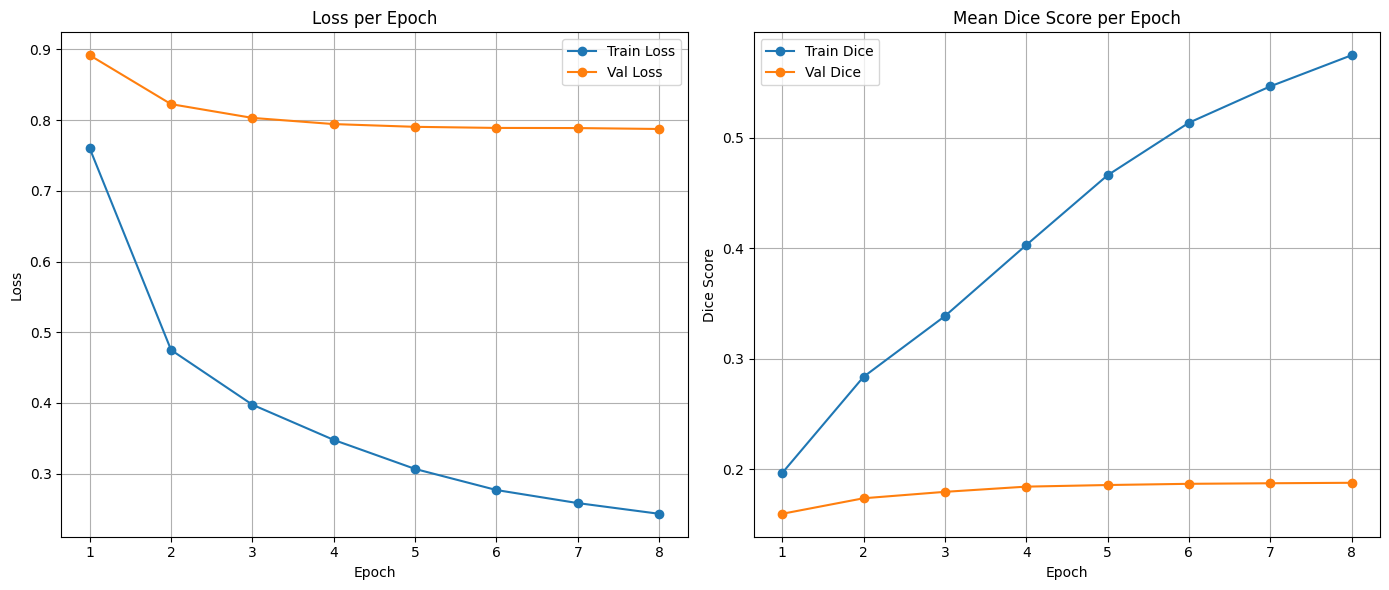

In [ ]:
import matplotlib.pyplot as plt

# Assuming history dictionary keys:
# "train_loss", "val_loss", "train_dice", "val_dice"
# each is a list with length = number of epochs

epochs = range(1, len(history["train_loss"]) + 1)

plt.figure(figsize=(14, 6))

# Plot losses
plt.subplot(1, 2, 1)
plt.plot(epochs, history["train_loss"], label="Train Loss", marker='o')
if any(history["val_loss"]):
    plt.plot(epochs, history["val_loss"], label="Val Loss", marker='o')
plt.title("Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

# Plot mean Dice scores
plt.subplot(1, 2, 2)
plt.plot(epochs, history["train_dice"], label="Train Dice", marker='o')
plt.plot(epochs, history["val_dice"], label="Val Dice", marker='o')
plt.title("Mean Dice Score per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Dice Score")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


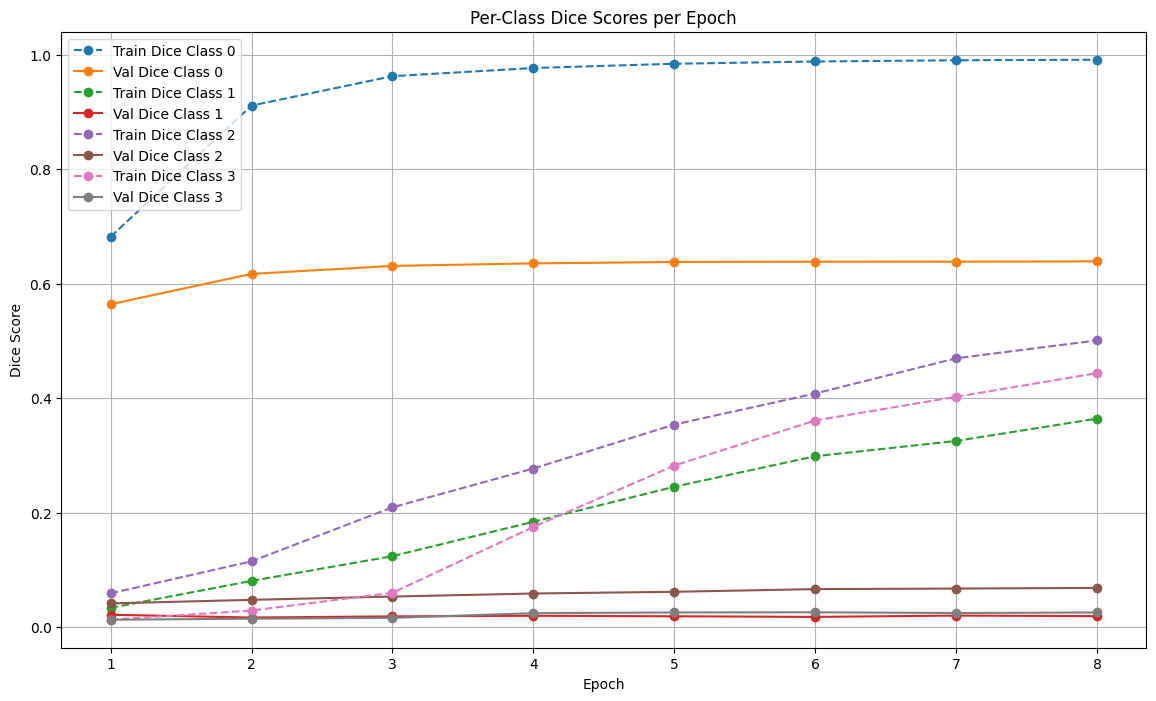

In [ ]:
import numpy as np

num_classes = len(history["train_dice_per_class"][0])  # e.g., 4

plt.figure(figsize=(14, 8))

for c in range(num_classes):
    train_cls = [epoch_vals[c] for epoch_vals in history["train_dice_per_class"]]
    val_cls = [epoch_vals[c] for epoch_vals in history["val_dice_per_class"]]

    plt.plot(epochs, train_cls, label=f"Train Dice Class {c}", linestyle='--', marker='o')
    plt.plot(epochs, val_cls, label=f"Val Dice Class {c}", marker='o')

plt.title("Per-Class Dice Scores per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Dice Score")
plt.legend()
plt.grid(True)
plt.show()
